In [1]:
# https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
# Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .



It contains the following 6 fields:

sentiment: the polarity of the tweet (0 = negative, 4 = positive)
ids: The id of the tweet (2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)

In [2]:
data = pd.read_csv("tweets.csv" , encoding='iso-8859-1')
data


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
# data.rename(columns = {"0":"sentiment" , "1467810369" :"IDs" , "Mon Apr 06 22:19:45 PDT 2009":"Dates","NO_QUERY":"flag","_TheSpecialOne_":"user"} , inplace = True)
data.columns = ["sentiment","IDs", "Dates" ,"flag", "user" ,"tweets"]

In [4]:
data.head(5)

,sentiment,IDs,Dates,flag,user,tweets
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
data.tail(5)

,sentiment,IDs,Dates,flag,user,tweets
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
data.shape

(1599999, 6)

we have 15999999 rows and 6 columns in total

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   IDs        1599999 non-null  int64 
 2   Dates      1599999 non-null  object
 3   flag       1599999 non-null  object
 4   user       1599999 non-null  object
 5   tweets     1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.describe()

,sentiment,IDs
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


# Correlation graph
 Before Handling the missing value first we find the correlation between the  missing values . have used the missingno package. It's a simple python package that can be used for missing data visualization. Visualizing correlation between missing values can give better insights about the missingness of data
 

<AxesSubplot:>

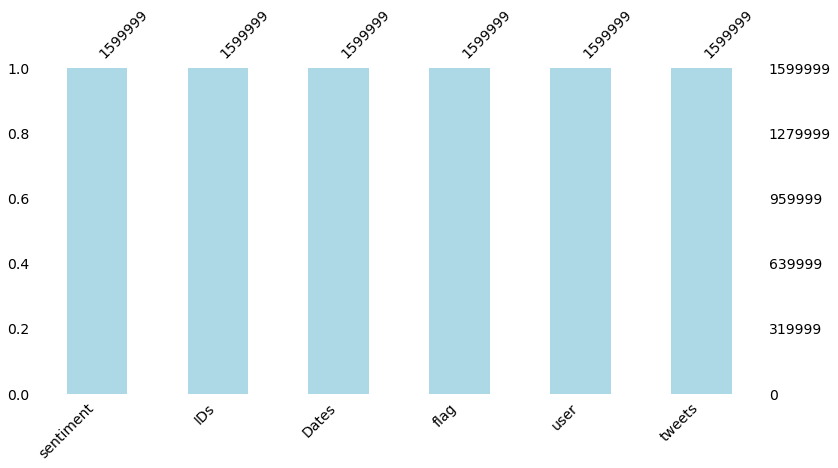

In [8]:
import missingno as msno
msno.bar(data,  figsize=(13, 6), fontsize=14  , color = "lightblue")

each bar represents a column within the dataframe. The height of the bar tells about how many values are non-null in that specific cloumn , i.e, how many non-null values are present. on left-hand-side y-axis there is scale range from 0 to 1.0 where 1.0 represents 100% data completeness.If bar has less then this then that column has some missing values . And on right-hand-side y-axis there is index present

In [10]:
data.isnull().sum()

sentiment    0
IDs          0
Dates        0
flag         0
user         0
tweets       0
dtype: int64

There are no null values present in this dataset

We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

# Removing the unnecessary columns 

In [9]:
data = data[["sentiment","tweets"]]

In [10]:
data

,sentiment,tweets
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [14]:
data = data.sample(n=100000)

In [15]:
data

,sentiment,tweets
1157253,4,Watching the sunrise. Very peaceful.
570989,0,Im really tired! (Follow @peterfacinelli)
778617,0,"@xxtyrxx Unfortunately Turturro was great, t..."
745147,0,@ejobdone - That would have been GREAT if you ...
468174,0,Feeling feverish and tired
...,...,...
1586987,4,@AlexFraiser good tip this worked
1011641,4,Dear @inspectorsarit - maybe i'm a wreck but l...
238146,0,He's 7 Months Old And Ive Missed Him Sooooo Mu...
1486886,4,i had fun at the pool party on friday. met so...


In [56]:
# replacing the values of sentiment 
data["sentiment"] = data["sentiment"].replace(4,1)

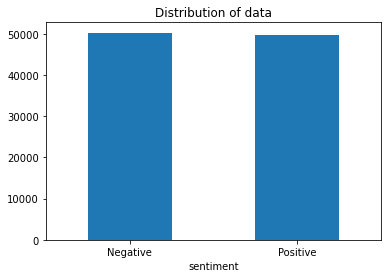

In [16]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False )
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(data['tweets']), list(data['sentiment'])

# Preprocess the text

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks . It transform the text in the suitable format

The Preprocessing steps taken are:

Lower Casing: Each text is converted to lowercase.
Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
Removing Short Words: Words with length less than 2 are removed.
Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [18]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such','t', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [19]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    
    
#     All the condition that are used to preprocessing the data 
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
text

# calculate time take to preprocess the data

NLTK (Natural Language Toolkit) is the go-to API for NLP (Natural Language Processing) with Python. It is a really powerful tool to preprocess text data for further analysis like with ML models for instance. It helps convert text into numbers, which the model can then easily work with.

In [20]:
import nltk 
processedtext = preprocess(text)

In [25]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 5 seconds


# Analyze the preprocessed data

# plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

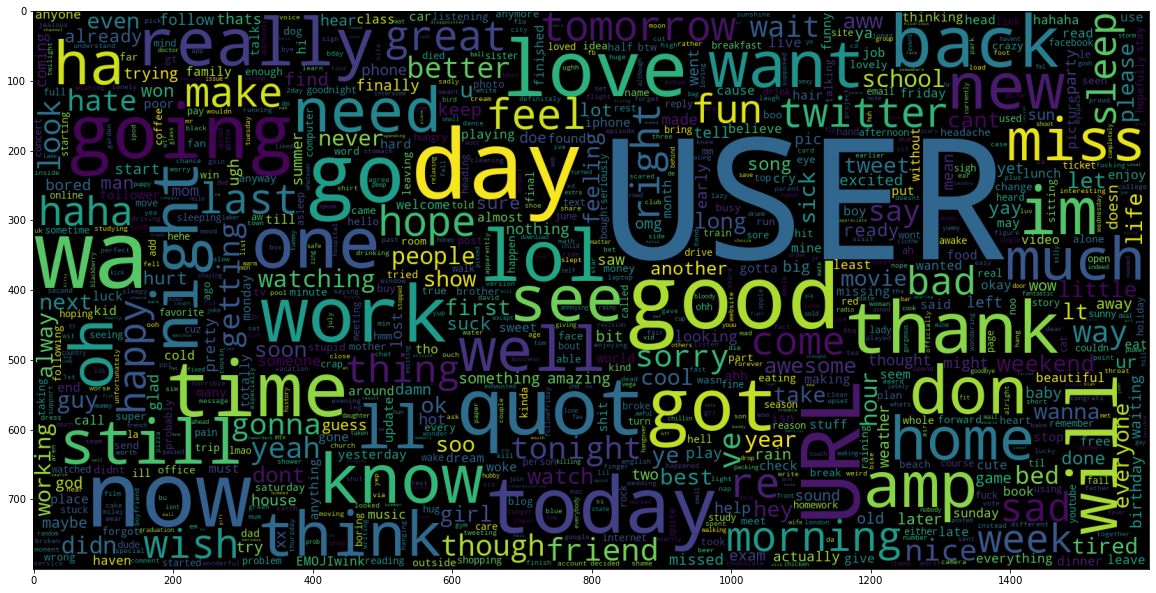

In [21]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [26]:
# For positive data

data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

ValueError: We need at least 1 word to plot a word cloud, got 0.

# Splitting the data
# Training Data: The dataset upon which the model would be trained on. Contains 95% data.
# Test Data: The dataset upon which the model would be tested against. Contains 5% data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)


In [30]:
X_train

['can concentrate ',
 'is at jocelyn til sunday sometime watching movie all day today because it is raining ',
 'at work wish wa at home relaxin or cleanin or maybe both new pic on myspace ',
 'carless in the pouring rain oa ',
 'ok must play loudly before resuming work water USER USER URL ',
 'just found my quot aswsutc vp quot name tag tear good time good time ',
 'missing charleston hubby ha duty day tomorrow feelin kinda down ',
 'USER kidding thsi heapps good ur gonna win wana be in the picture ',
 'please take me outta my body to smell california and sweet hypocrisy last night on mill with pic before go home ',
 'morning folk coffee is on me or tea whichever you prefer ',
 'USER right you are ',
 'just heard some really sad news ',
 'gotta get up super early but dont wanna go to bed ',
 'USER thanks ',
 'and yes baby had good time ',
 'USER lol not today only with myself on the down low but am little tired today ',
 'yesterday wa the first day ever wore bikini in my life felt so 

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

In [33]:

# TF-IDF indicates what the importance of the word is in order to understand the document or dataset
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  449058


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# Tranforming the dataset
# Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'the Data is Transformed.')

the Data is Transformed.


 Creating and evaluating the models 
 We're creating 3 different types of model for our sentiment analysis problem:

 Bernoulli Naive Bayes (BernoulliNB)
 Linear Support Vector Classification (LinearSVC)
 Logistic Regression (LR)
#Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions
# we find the accuracy and confusion matrix to get understanding of how model perform on the models


In [36]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      2493
           4       0.79      0.79      0.79      2507

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



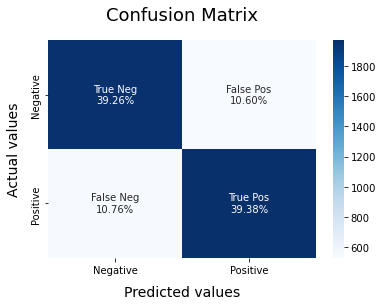

In [37]:
# BernoulliNb MODEL
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2493
           4       0.81      0.79      0.80      2507

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



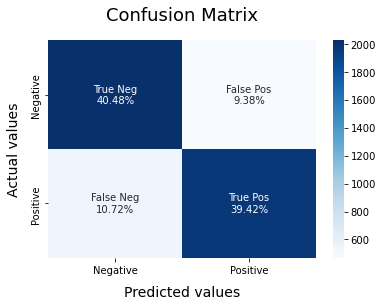

In [38]:
# LinearSVC Model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2493
           4       0.82      0.79      0.80      2507

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



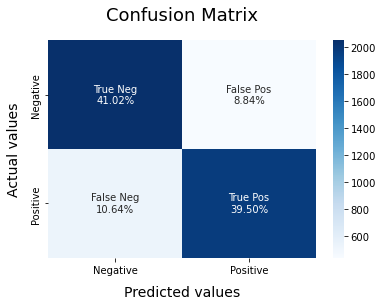

In [39]:
# Logistic regression models
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

We can clearly see that the Logistic Regression Model performs the best out of all the different models that we tried. It achieves nearly 82% accuracy while classifying the sentiment of a tweet.

Although it should also be noted that the BernoulliNB Model is the fastest to train and predict on. It also achieves 80% accuracy while calssifying.

In [ ]:

# To use the model for Sentiment Prediction we need to import the Vectoriser and LR Model using Pickle.

# The vectoriser can be used to transform data to matrix of TF-IDF Features. While the model can be used to predict the sentiment of the transformed Data. The text whose sentiment has to be predicted however must be preprocessed.

In [40]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
     # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"
            ]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())
                            

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.         4
2  Mr. Stark, I don't feel so good  Negative
